## Conv4_3D_res_v2
* key features
    * 4-20 Conv layers
        * 2 residual parts of (Convolution block + 2 Identity blocks)
    * 2 dropout layers (rate=0.7) + 2 dropout (rate=0.4) after residual Convs
    * SWISH activation functions
    * Nadam optimizer
    * 5 models trained on 5 cross-validation-like subsets of data for systematic error analysis on each class

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import os, re, gc, shutil
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from cnn_utils import *

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D, Concatenate, Add
from keras import optimizers
from keras.models import Model, load_model
from keras.constraints import MaxNorm
from keras.callbacks import TensorBoard

import tensorflow as tf
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects
K.set_image_data_format('channels_last')

#tf.logging.set_verbosity(tf.logging.ERROR)
[d.device_type+' '+str(d.memory_limit_bytes//1024**2)+' Mb' for d in K.get_session().list_devices() if "GPU" in d.name]

Using TensorFlow backend.


['XLA_GPU 16384 Mb', 'GPU 2367 Mb']

In [2]:
#from tensorflow.python.client import device_lib
# TensorFlow wizardry
#config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
#config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
#K.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
def swish(x):
    """
    x*sigmoid(x)
    """
    return (K.sigmoid(x) * x)
# adding a custom activation function
get_custom_objects().update({'swish': swish})


def identity_block(X, f, filters, stage, block):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_D_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_D, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv3D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('swish')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv3D(filters=F2, kernel_size= f, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name= conv_name_base+'2b')(X)
    X = BatchNormalization(axis=3, name= bn_name_base+'2b')(X)
    X = Activation('swish')(X)

    # Third component of main path (≈2 lines)
    X = Conv3D(filters=F3, kernel_size=1, padding='valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a SWISH activation (≈2 lines)
    X = Add()([X, X_shortcut])#X+X_shortcut
    X = Activation('swish')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_D_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_D, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv3D(F1, 1, strides = s, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('swish')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv3D(F2, f, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), padding='same', name=conv_name_base+'2b')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2b')(X)
    X = Activation('swish')(X)

    # Third component of main path (≈2 lines)
    X = Conv3D(F3, 1, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv3D(F3, 1, strides=s, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=-1, name=bn_name_base+'1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a SWISH activation (≈2 lines)
    X = Add()([X, X_shortcut]) #X+X_shortcut
    X = Activation('swish')(X)
    
    X = Dropout(rate=0.4, name='drop'+str(stage)+block)(X)
    
    return X

def conv_res_3d_model(input_shape=(32,32,8,1)):
    
    X_input = Input(input_shape)

    X = Conv3D(64, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_1')(X_input)
    X = Conv3D(64, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_2')(X)
    X = MaxPooling3D(name='pool1')(X)
    #print('conv1\t',X.get_shape())
    
    #X = Dropout(rate=0.3, name='drop_start')(X)
    
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    #print('conv2\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop_middle')(X)
    
    X = convolutional_block(X, f = 3, filters = [128,128, 512], stage = 3, block='a')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='c')
    X = MaxPooling3D(padding='same', name='pool3')(X)
    #print('conv3\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop')(X)
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='class')(X)
    
    return Model(inputs = X_input, outputs = X, name='conv_res_model')

In [4]:
def no_rot_train(class_names=None, bckg='fog', N_ep=5, batch=256, n_fold=3, lr=1e-4, beta_1=0.95, beta_2=0.999, dset=None, verb=1):
    i=0
    if not class_names: class_names = ['C30keV']
    load_s = []
    for n in class_names:
        load_s += [(n,str(i)) for i in range(1,n_fold+1)]
    X, y, shuffs = {},{},{}
    for s in class_names:
        print('\n\tFor validation on '+s+' vs '+bckg)
        X[s], y[s], shuffs[s] = load_data_v2(classes={'s_'+s:'full', 'b_'+bckg:'full'}, tr_val_test=[False,True,False],
                                             im_ft=[True,False], path_h5=dset, shuf_ind={}, verbose=1, stratify=True)
    print('')
    if os.path.exists('logs/carbon_'+bckg+'/no_rot'): shutil.rmtree('logs/carbon_'+bckg+'/no_rot')
    for s, p in load_s:
        if p=='1': print('')
        K.clear_session()
        nadamka = optimizers.Nadam(lr=lr, beta_1=beta_1, beta_2=beta_2)
        print('FOLD '+p+':\t'+s+' part '+p+'/'+str(n_fold)+' vs '+bckg+' part '+p+'/'+str(n_fold))
        fold = datetime.now()
        
        X_tr, y_tr, shuffs_tr = load_data_v2(classes={'s_'+s:p, 'b_fog':p}, n_folds=n_fold, tr_val_test=[True,False,False],
                                                     im_ft=[True,False], path_h5=dset, verbose=1, stratify=True)
        gc.collect()
        conv4_3d_res = conv_res_3d_model(input_shape=X_tr['/images/train'].shape[1:])
        conv4_3d_res.compile(optimizer=nadamka, loss='binary_crossentropy')
        hist_roc = call_roc_hist()
        t_board = TensorBoard(log_dir='./logs/carbon_fog/no_rot/'+s+'_'+p, histogram_freq=5, batch_size=batch, write_graph=False,
                              write_grads=True, write_images=False)
        hist = conv4_3d_res.fit(x=X_tr['/images/train'], y=y_tr['/images/train'], batch_size=batch, epochs=N_ep,
                                validation_data=(X[s]['/images/val'],y[s]['/images/val']), callbacks=[hist_roc, t_board],
                                verbose=verb)
        print('\tfold training time ', datetime.now()-fold)
        print('\ttraining loss: ',np.around(hist.history['loss'][-1],decimals=4),
              '\t validation loss: ',np.around(hist.history['val_loss'][-1],decimals=4),
              '\tROC AUC: ',np.around(hist_roc.val_aucs[-1],decimals=4))
        print('')
        
        if not os.path.exists('outputs/conv4_3d_res/v2/no_rot/'):
            os.makedirs('outputs/conv4_3d_res/v2/no_rot/')
        np.savetxt('outputs/conv4_3d_res/v2/no_rot/'+s+'-'+p+'_roc_auc_'+str(N_ep)+'.txt', hist_roc.val_aucs)
        np.savetxt('outputs/conv4_3d_res/v2/no_rot/'+s+'-'+p+'_loss_train_'+str(N_ep)+'.txt', hist.history['loss'])
        np.savetxt('outputs/conv4_3d_res/v2/no_rot/'+s+'-'+p+'_loss_val_'+str(N_ep)+'.txt', hist.history['val_loss']) 
        if not os.path.exists('networks/res_v2/e'+str(N_ep)+'/no_rot/'):
            os.makedirs('networks/res_v2/e'+str(N_ep)+'/no_rot/')
        conv4_3d_res.save('networks/res_v2/e'+str(N_ep)+'/no_rot/conv4_3d_res_'+s+'-'+p+'.h5')

        for n in class_names:
            preds = conv4_3d_res.predict(X[n]['/images/val'], batch_size=batch, verbose=0)
            #print('ROC AUC ',roc_auc_score(y[n]['/images/val'],preds))
            preds = np.vstack((np.squeeze(preds),y[n]['/images/val'])).T
            if not os.path.exists('outputs/conv4_3d_res/v2/preds/no_rot/'):
                os.makedirs('outputs/conv4_3d_res/v2/preds/no_rot/')
            np.savetxt('outputs/conv4_3d_res/v2/preds/no_rot/'+'e'+str(N_ep)+'_'+n+'_'+s+'-'+p+'.txt',preds)
        del X_tr, y_tr, shuffs_tr
        del hist, hist_roc, conv4_3d_res, preds
        gc.collect()
    return True

In [5]:
class_names = ['C100keV', 'C60keV', 'C30keV']
dset = '/mnt/ML-drive/Artem/Python/NEWS/data/dataset_phys_clean.h5'
lr = 1e-4; beta_1 = 0.95; beta_2 = 0.999
N_ep = 10; batch = 64; i=0; n_fold = 4
print('Training in ',n_fold,' folds for ',N_ep,' epochs with batch_size =',batch)
print('The optimizer is Nadam:\n\tinitial lr =',lr,'\tbeta_1 =',beta_1,'\tbeta_2 =',beta_2,'\n')
start = datetime.now()
no_rot_train(class_names=class_names, bckg='fog', N_ep=N_ep, batch=batch, n_fold=n_fold, lr=lr, beta_1=beta_1, beta_2=beta_2,
           dset=dset, verb=1)
print('\nTotal training time ', datetime.now()-start)

Training in  4  folds for  10  epochs with batch_size = 64
The optimizer is Nadam:
	initial lr = 0.0001 	beta_1 = 0.95 	beta_2 = 0.999 


	For validation on C100keV vs fog
Number of val C100keV samples: 	 9401
Number of fog samples: 	 9401

	For validation on C60keV vs fog
Number of val C60keV samples: 	 9401
Number of fog samples: 	 9401

	For validation on C30keV vs fog
Number of val C30keV samples: 	 9401
Number of fog samples: 	 9401


FOLD 1:	C100keV part 1/4 vs fog part 1/4
Number of train C100keV samples: 	 57042
Number of fog samples: 	 57042
Train on 114084 samples, validate on 18802 samples
Epoch 1/10
114084/114084 [==============================] - 732s 6ms/step - loss: 0.2898 - val_loss: 0.2034
Epoch 2/10
114084/114084 [==============================] - 716s 6ms/step - loss: 0.0849 - val_loss: 0.0876
Epoch 3/10
114084/114084 [==============================] - 717s 6ms/step - loss: 0.0570 - val_loss: 0.0699
Epoch 4/10
114084/114084 [==============================] - 719s 6ms

In [9]:
load_s = []
for n in class_names:
    load_s += [(n,str(i)) for i in range(1,n_fold+1)]
tr_loss, val_loss, hist_roc = {},{},{}
for s, p in load_s:
    hist_roc[s+p] = np.loadtxt('outputs/conv4_3d_res/v2/no_rot/'+s+'-'+p+'_roc_auc_'+str(N_ep)+'.txt')
    tr_loss[s+p] = np.loadtxt('outputs/conv4_3d_res/v2/no_rot/'+s+'-'+p+'_loss_train_'+str(N_ep)+'.txt')
    val_loss[s+p] = np.loadtxt('outputs/conv4_3d_res/v2/no_rot/'+s+'-'+p+'_loss_val_'+str(N_ep)+'.txt')

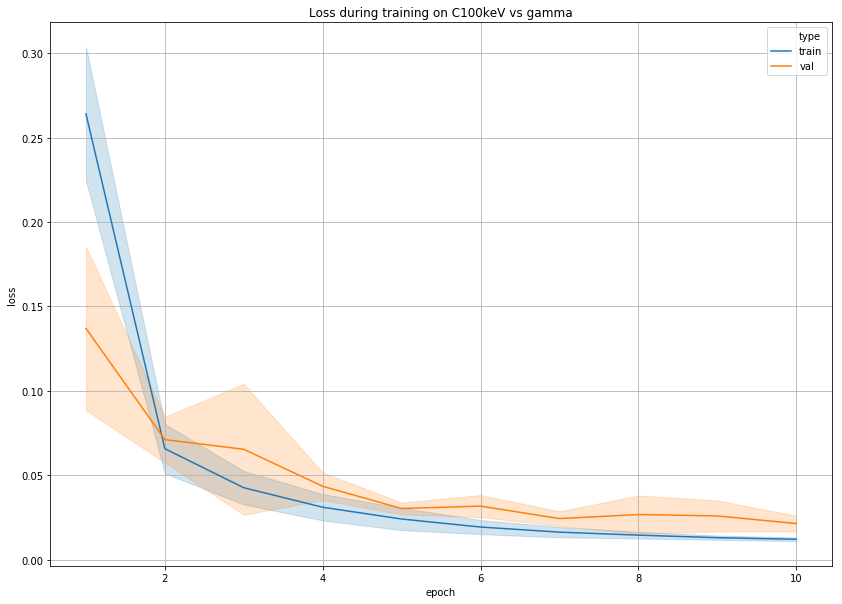

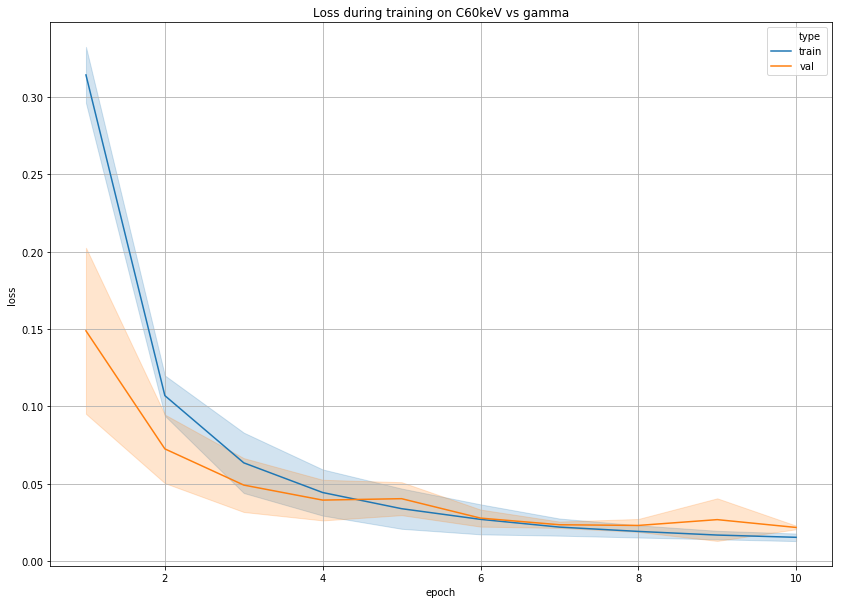

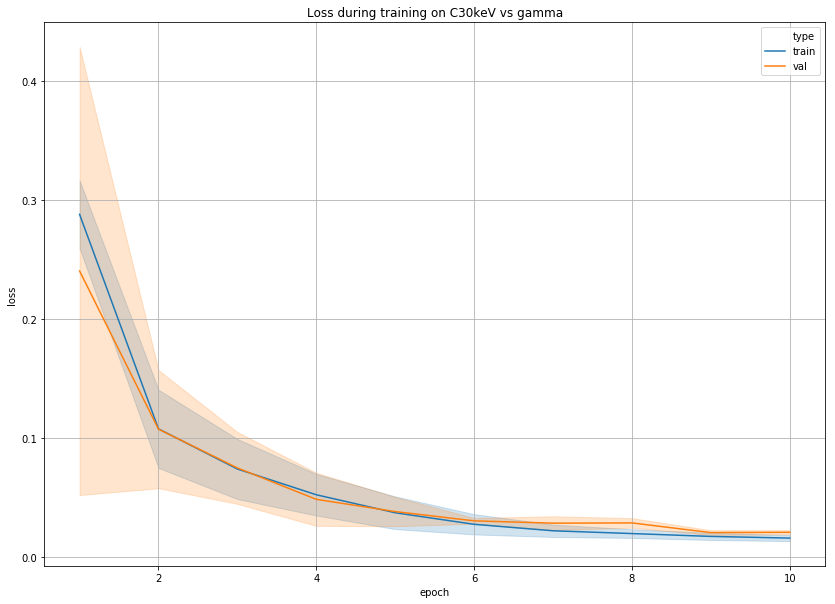

In [10]:
loss = {}
loss['epoch'], loss['type'], loss['loss'], loss['class'] = [],[],[],[]
for n in class_names:
    for s in [k for k in hist_roc.keys() if n in k]:
        e = 1
        for l, vl in zip(tr_loss[s],val_loss[s]):
            loss['epoch'].append(e); loss['type'].append('train'); loss['loss'].append(l); loss['class'].append(n)
            loss['epoch'].append(e); loss['type'].append('val'); loss['loss'].append(vl); loss['class'].append(n)
            e += 1
loss = pd.DataFrame(data=loss)

for n in class_names:
    plt.figure(figsize=(14,10))
    sns.lineplot(x='epoch',y='loss',hue='type', data=loss[loss['class']==n], ci='sd')
    plt.grid()
    plt.title('Loss during training on '+n+' vs gamma')
    plt.show()

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


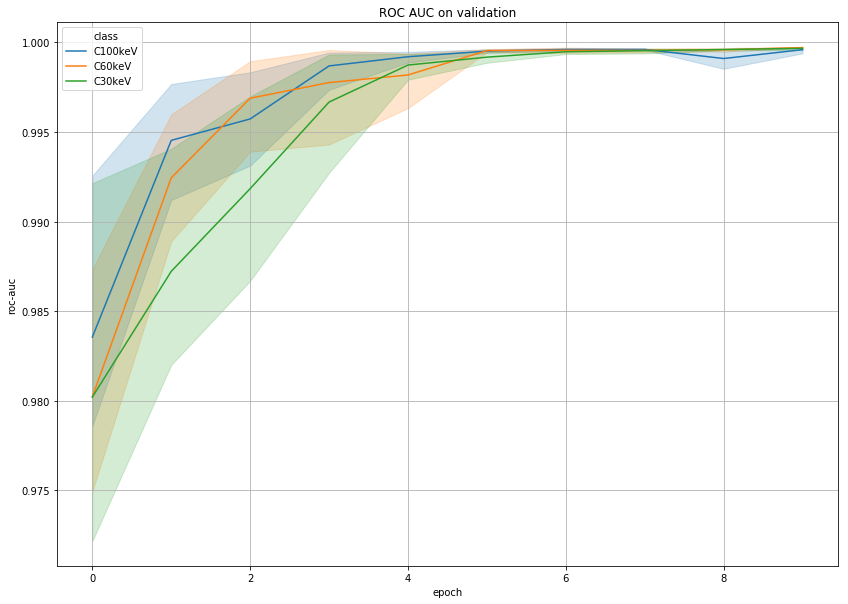

In [12]:
aucs = {}
aucs['epoch'], aucs['roc-auc'], aucs['class'] = [],[],[]
for n in class_names:
    for s in [k for k in hist_roc.keys() if n in k]:
        for e, au in enumerate(hist_roc[s]):
            aucs['epoch'].append(e); aucs['roc-auc'].append(au); aucs['class'].append(n)
aucs = pd.DataFrame(data=aucs)

plt.figure(figsize=(14,10))
sns.lineplot(x='epoch',y='roc-auc', hue='class', data=aucs)
plt.grid()
_ = plt.title('ROC AUC on validation')

In [13]:
gc.collect()

12129